In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import seaborn as sns

from settings import *
from utils import *
from quoteAnalysis import *

In [2]:
#Run the pipeline to prepare the dataframe for the plots
documents = quotePipeline()

extractQuotes ran in 45.698s.
Total number of quotes: 2.79K
Average number of quotes per Document: 2.79
discoverTopics ran in 38.321s.
Total time: 84.019s.


In [3]:
documents = documents.toPandas()
documents['quoteTopic'].value_counts()

company                1436
health                 703 
product                342 
sugar                  190 
fight                  39  
glyphosate             21  
consumption            13  
person                 12  
food truck             8   
cooking                7   
climate change         7   
salmonella outbreak    3   
chocolate              2   
packaging              2   
listeria               2   
public                 1   
cost                   1   
baby                   1   
Name: quoteTopic, dtype: int64

/opt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


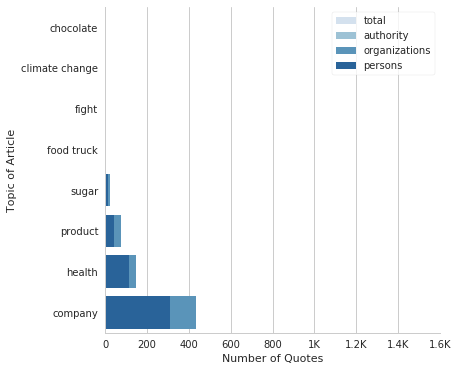

In [4]:
def plotNumOfQuotes():
    
    #Filter (aesthetic purposes)
    countLimit = 0

    #Data manipulation
    total = pd.DataFrame(documents.groupby(['articleTopic']).size().sort_values().rename('count')).reset_index()
    total = total[total['count'] > countLimit]
    topics = total['articleTopic']
    person = pd.DataFrame(documents.query("quoteeType == 'PERSON' & articleTopic in @topics").groupby(['articleTopic']).size().sort_values().rename('count')).reset_index()
    personorg = pd.DataFrame(documents.query("quoteeType in ['PERSON', 'ORG'] & articleTopic in @topics").groupby(['articleTopic']).size().sort_values().rename('count')).reset_index()
    personorgauth = pd.DataFrame(documents.query("(quotee == 'authority' | quoteeType in ['PERSON', 'ORG']) & articleTopic in @topics").groupby(['articleTopic']).size().sort_values().rename('count')).reset_index()
    
    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))
    colors = sns.color_palette("Blues",  n_colors=4)

    #Barplots
    sns.barplot(x="count", y="articleTopic", data=total, ax=ax, label="total", color=colors[0])
    sns.barplot(x="count", y="articleTopic", data=personorgauth, ax=ax, label="authority", color=colors[1])
    sns.barplot(x="count", y="articleTopic", data=personorg, ax=ax, label="organizations", color=colors[2])
    sns.barplot(x="count", y="articleTopic", data=person, ax=ax, label="persons", color=colors[3])

    #Labels
    ax.set(ylabel="Topic of Article", xlabel="Number of Quotes")
    ax.legend(ncol=1, loc="upper right", frameon=True)
    sns.despine()
    locs, labels = plt.xticks()
    labels = [human_format(l) for l in locs]
    plt.xticks(locs, labels)

    #Depiction
    plt.savefig('plots/CountQuotes.png', dpi=1200, bbox_inches = 'tight')
    plt.show()
plotNumOfQuotes()

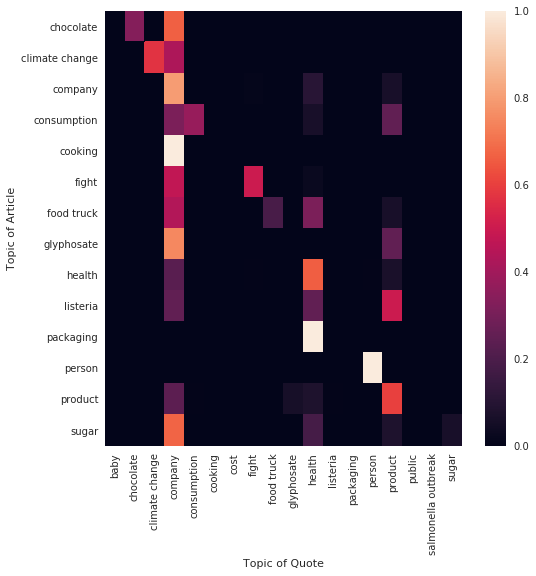

In [5]:
def plotHeatMap():
    
    #Data manipulation
    data = documents[documents['quoteSim']>0.1][['articleTopic', 'quoteTopic']].groupby(['articleTopic', 'quoteTopic']).size().reset_index(name='counts').pivot(index='articleTopic', columns='quoteTopic', values='counts').fillna(0)
    #normalization
    data = data.div(data.sum(axis=1), axis=0)
    
    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(8, 8))
    sns.set_color_codes("pastel")

    #Plot
    ax = sns.heatmap(data)

    #Labels
    ax.set(ylabel="Topic of Article", xlabel="Topic of Quote")
    
    #Depiction
    plt.savefig('plots/TopicsHeatMap.png', dpi=1200, bbox_inches = 'tight')
    plt.show()    
plotHeatMap()

/opt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


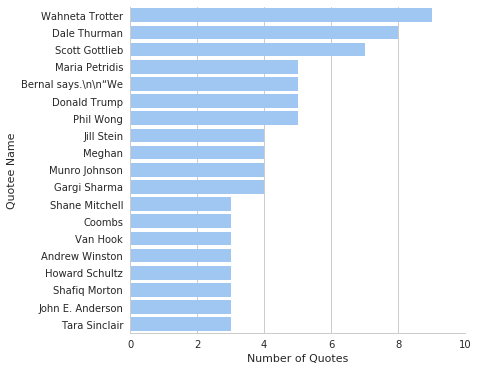

In [6]:
def plotTopQuotees():
    
    #Data manipulation    
    data = documents[documents['quoteeType'] == 'PERSON']['quotee'].value_counts().reset_index()
    data.columns = ['quotee', 'count']
    data = data.head(20)
    data = data.drop(3) # dropping â

    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))

    #Barplots
    sns.set_color_codes("pastel")
    sns.barplot(x="count", y="quotee", data=data, ax=ax, label="total", color='b')

    #Labels
    ax.set(ylabel="Quotee Name", xlabel="Number of Quotes")
    sns.despine()
    locs, labels = plt.xticks()
    labels = [human_format(l) for l in locs]
    plt.xticks(locs, labels)

    #Depiction
    plt.savefig('plots/TopQuotees.png', dpi=1200, bbox_inches = 'tight')
    plt.show()
plotTopQuotees()

/opt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


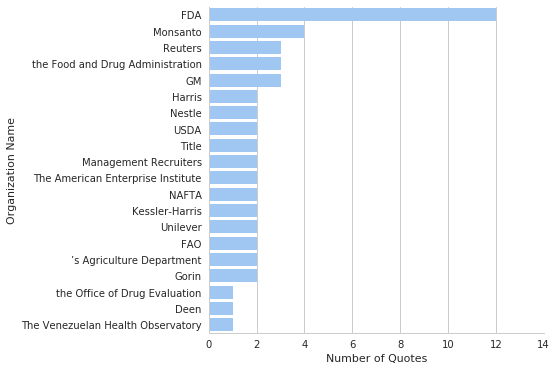

In [7]:
def plotTopOrganizations():
    
    #Data manipulation    
    data = documents[documents['quoteeType'] == 'ORG']['quoteeAffiliation'].value_counts().reset_index()
    data.columns = ['organization', 'count']
    data = data.head(20)
    #data = data.drop(3) # dropping â

    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))

    #Barplots
    sns.set_color_codes("pastel")
    sns.barplot(x="count", y="organization", data=data, ax=ax, label="total", color='b')

    #Labels
    ax.set(ylabel="Organization Name", xlabel="Number of Quotes")
    sns.despine()
    locs, labels = plt.xticks()
    labels = [human_format(l) for l in locs]
    plt.xticks(locs, labels)

    #Depiction
    plt.savefig('plots/TopOrganizations.png', dpi=1200, bbox_inches = 'tight')
    plt.show()
plotTopOrganizations()